In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu118
cuda:0


In [2]:
!pwd

/g/wangdao_python_short_class/DeepLearning/Day29_machine_translation2


## 数据加载


### 数据清洗

In [3]:
import unicodedata
import re
from sklearn.model_selection import train_test_split

# 因为西班牙语中有一些特殊字符，我们需要将Unicode字符转换为ASCII字符，
# 这样可以减少字符的大小，因为Unicode字符集较大。
def unicode_to_ascii(s):
    # 使用NFD方法进行Unicode规范化，将字符分解为基本字符和重音符号。
    # 'Mn'表示非间距标记（如重音符号），我们通过过滤掉这些标记来去除重音。
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# 下面我们使用一个样本来测试这个函数。
# 在字符串前加'u'表示对字符串进行Unicode编码。
en_sentence = u"May I borrow this book?"  # 英语句子
sp_sentence = u"¿Puedo tomar prestado este libro?"  # 西班牙语句子

# 打印转换后的句子
print(unicode_to_ascii(en_sentence))  # 输出: May I borrow this book?
print(unicode_to_ascii(sp_sentence))  # 输出: ¿Puedo tomar prestado este libro?

May I borrow this book?
¿Puedo tomar prestado este libro?


In [4]:
def preprocess_sentence(w):
    # 将句子转换为小写，并去掉开头和结尾的多余空格
    # 同时调用 unicode_to_ascii 函数将特殊字符转换为 ASCII 字符
    w = unicode_to_ascii(w.lower().strip())
    # 在单词与标点符号之间插入空格
    # 例如："he is a boy." => "he is a boy . "
    # 参考：https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    # 将多个连续空格替换为单个空格
    w = re.sub(r'[" "]+', " ", w)
    # 只保留字母和部分标点符号（a-z, A-Z, ".", "?", "!", ","），其他字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    # 去掉句子开头和结尾的空格
    w = w.rstrip().strip()
    return w

# 测试预处理函数
print(preprocess_sentence(en_sentence))  # 输出: may i borrow this book ?
print(preprocess_sentence(sp_sentence))  # 输出: ¿ puedo tomar prestado este libro ?

# 打印西班牙语句子的 UTF-8 编码
# 注意：¿ 是占用两个字节的字符
print(preprocess_sentence(sp_sentence).encode('utf-8'))  # 输出: b' \xc2\xbf puedo tomar prestado este libro ?'

may i borrow this book ?
¿ puedo tomar prestado este libro ?
b'\xc2\xbf puedo tomar prestado este libro ?'


### Dataset
把英语和西班牙语分开

In [5]:
# 例子：使用zip
# 定义一个包含多个子列表的列表
a = [[1, 2], [4, 5], [7, 8]]
# 使用 zip(*a) 对列表进行解包和重新组合
# *a 表示将 a 中的子列表作为单独的参数传递给 zip 函数
# zip 函数会将每个子列表中相同位置的元素组合成一个元组
zipped = list(zip(*a))
# 打印结果
print(zipped)

[(1, 4, 7), (2, 5, 8)]


In [6]:
# 例子：np.random.choice()划分训练集和测试集
# 生成一个大小为 100 的数组，数组中的值为 "train" 或 "test"
# 选择 "train" 和 "test" 的概率分别为 0.9 和 0.1
# replace=True 表示允许重复抽样
split_index1 = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=100)
# 输出生成的随机分类索引
split_index1

array(['train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'test', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'test', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'test', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train'], dty

In [7]:
!wc -l data_spa_en/spa.txt

118964 data_spa_en/spa.txt


In [8]:
# 查看分隔符
with open("./data_spa_en/spa.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# 只查看前几行
for line in lines[:5]:
    print(repr(line))  # 用 repr() 让隐藏字符（如 \t）可见

'Go.\tVe.\n'
'Go.\tVete.\n'
'Go.\tVaya.\n'
'Go.\tVáyase.\n'
'Hi.\tHola.\n'


In [9]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

class LangPairDataset(Dataset):
    fpath = Path(r"./data_spa_en/spa.txt")  # 数据文件路径
    cache_path = Path(r"./.cache/lang_pair.npy")  # 缓存文件路径
    split_index = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=118964)  # 生成 118964 个 "train" 或 "test" 标签，按 9:1 的比例划分数据集

    def __init__(self, mode="train", cache=False):
        if cache or not self.cache_path.exists():  # 如果缓存不存在或者需要重新缓存，则处理数据
            self.cache_path.parent.mkdir(parents=True, exist_ok=True)  # 创建缓存目录（如果不存在）
            with open(self.fpath, "r", encoding="utf8") as file:
                lines = file.readlines()  # 读取数据文件中的所有行
                lang_pair = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines]  # 预处理句子，并转换成 (目标语言, 源语言) 格式
                trg, src = zip(*lang_pair)  # 拆分目标语言（英语）和源语言（西班牙语）
                trg = np.array(trg)  # 转换为 NumPy 数组
                src = np.array(src)  # 转换为 NumPy 数组
                np.save(self.cache_path, {"trg": trg, "src": src})  # 以字典形式保存数据到缓存文件
        else:
            lang_pair = np.load(self.cache_path, allow_pickle=True).item()  # 读取缓存文件
            trg = lang_pair["trg"]  # 加载目标语言数据
            src = lang_pair["src"]  # 加载源语言数据

        # 根据 split_index 进行数据划分
        self.trg = trg[self.split_index == mode]  # 获取 mode 指定的目标语言数据
        self.src = src[self.split_index == mode]  # 获取 mode 指定的源语言数据

    # 用于数据索引
    def __getitem__(self, index):
        return self.src[index], self.trg[index]  # 返回源语言和目标语言句子对

    # 用于数据集大小
    def __len__(self):
        return len(self.src)  # 返回数据集大小

# 创建训练集和测试集
train_ds = LangPairDataset("train")
test_ds = LangPairDataset("test")

In [10]:
print("source: {}\ntarget: {}".format(*train_ds[-1]))
# 打印train_ds的大小
print(len(train_ds))
# 打印test_ds的大小
print(len(test_ds))

source: si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado .
target: if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo .
107259
11705


### Tokenizer

这里有两种处理方式，分别对应着 encoder 和 decoder 的 word embedding 是否共享，这里实现不共享的方案。

#### 生成词表

In [11]:
from collections import Counter

def get_word_idx(ds, mode="src", threshold=2):
    # 载入词表，初始化特殊 token
    word2idx = {
        "[PAD]": 0,     # 填充 token
        "[BOS]": 1,     # 句子起始 token
        "[UNK]": 2,     # 未知 token
        "[EOS]": 3,     # 句子结束 token
    }
    idx2word = {value: key for key, value in word2idx.items()}  # 反向词表：索引 -> 词
    index = len(idx2word)  # 记录当前索引，方便后续添加单词
    threshold = 1  # 设定词频阈值，出现次数低于此的 token 被舍弃

    # 提取数据集中指定语言 (src 或 trg) 的所有文本
    # `ds` 是一个数据集，其中每个元素是一个 (src, trg) 对
    # 如果 mode 为 "src"，选择 pair[0]（源语言）；否则选择 pair[1]（目标语言）
    word_list = " ".join([pair[0 if mode == "src" else 1] for pair in ds]).split()

    # 统计词频，Counter 是一个字典，键为单词，值为出现次数
    counter = Counter(word_list)
    print("word count:", len(counter))  # 输出词表大小

    # 遍历词频统计结果，将频率大于等于 threshold 的单词加入词表
    for token, count in counter.items():
        if count >= threshold:
            word2idx[token] = index  # 词表：单词 -> 索引
            idx2word[index] = token  # 反向词表：索引 -> 单词
            index += 1  # 更新索引

    return word2idx, idx2word  # 返回词表和反向词表

# 生成源语言（西班牙语）的词表
src_word2idx, src_idx2word = get_word_idx(train_ds, "src")
# 生成目标语言（英语）的词表
trg_word2idx, trg_idx2word = get_word_idx(train_ds, "trg")

word count: 23715
word count: 12500


In [12]:
# 查看去除低频词的词表
print("src_word2idx:", len(src_word2idx))
print("src_idx2word:", len(src_idx2word))
print("trg_word2idx:", len(trg_word2idx))
print("trg_idx2word:", len(trg_idx2word))

src_word2idx: 23719
src_idx2word: 23719
trg_word2idx: 12504
trg_idx2word: 12504


#### encode 和 decode

In [13]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        # 词汇表映射
        self.word2idx = word2idx  # 词 -> 索引
        self.idx2word = idx2word  # 索引 -> 词
        self.max_length = max_length  # 最大序列长度
        self.pad_idx = pad_idx  # 填充索引
        self.bos_idx = bos_idx  # 句子起始符索引
        self.eos_idx = eos_idx  # 句子结束符索引
        self.unk_idx = unk_idx  # 未知词索引

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """
        将文本列表编码为索引序列，并进行填充。
        参数：
        - text_list: 输入文本的列表，每个元素是一个单词列表。
        - padding_first: 是否将填充 [PAD] 加在序列前面，默认为 False（填充在后面）。
        - add_bos: 是否在序列前添加 [BOS] 标记。
        - add_eos: 是否在序列后添加 [EOS] 标记。
        - return_mask: 是否返回填充掩码，掩码用于指示哪些部分是填充，哪些是真实 token。
        返回：
        - input_ids: 转换后的索引张量（torch.Tensor）。
        - masks（可选）: 掩码张量（torch.Tensor），填充部分为 1，非填充部分为 0。
        """
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))  # 计算最大序列长度，在500和批次的最大值中取小者
        indices_list = []

        for text in text_list:
            # 将文本转换为索引，若单词不在词表中则使用 unk_idx
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]] # 如果word存在，则取索引，否则取unk_idx

            # 添加起始符 [BOS] 和结束符 [EOS]
            if add_bos:
                indices = [self.bos_idx] + indices
            if add_eos:
                indices = indices + [self.eos_idx]

            # 根据 padding_first 选择填充方式
            if padding_first:
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices))

            indices_list.append(indices)

        input_ids = torch.tensor(indices_list)  # 转换为张量
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64)  # 生成掩码：填充部分为 1，非填充部分为 0

        return input_ids if not return_mask else (input_ids, masks)

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        """
        将索引序列解码回文本。
        参数：
        - indices_list: 需要解码的索引列表，每个元素是一个索引序列。
        - remove_bos: 是否移除 [BOS] 。
        - remove_eos: 是否移除 [EOS] 。
        - remove_pad: 是否移除 [PAD] 。
        - split: 是否返回单词列表（True），否则返回字符串（False）。
        返回：
        - text_list: 解码后的文本列表。
        """
        text_list = []

        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")  # 获取单词，如果索引不存在则替换为 [UNK]

                # 根据参数决定是否移除特殊标记
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break

                text.append(word)  # 添加单词

            text_list.append(" ".join(text) if not split else text)  # 连接单词形成句子

        return text_list

# 生成源语言（西班牙语）和目标语言（英语）的 Tokenizer
src_tokenizer = Tokenizer(word2idx=src_word2idx, idx2word=src_idx2word)  # 源语言 tokenizer
trg_tokenizer = Tokenizer(word2idx=trg_word2idx, idx2word=trg_idx2word)  # 目标语言 tokenizer

In [14]:
# 测试 encode 和 decode 功能
raw_text = [
    "hello world".split(),
    "tokenize text datas with batch".split(),
    "this is a test".split()
]
# 编码文本
indices, mask = trg_tokenizer.encode(raw_text, padding_first=False, add_bos=True, add_eos=True, return_mask=True)
# 解码索引
decode_text = trg_tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)

# 打印测试结果
print('-' * 10 + "raw text" + '-' * 10)
for raw in raw_text:
    print(raw)

print('-' * 10 + "mask" + '-' * 10)
for m in mask:
    print(m)

print('-' * 10 + "indices" + '-' * 10)
for index in indices:
    print(index)

print('-' * 10 + "decode text" + '-' * 10)
for decode in decode_text:
    print(decode)

----------raw text----------
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
----------mask----------
tensor([0, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1])
----------indices----------
tensor([   1,   16, 3218,    3,    0,    0,    0])
tensor([   1,    2, 3878,    2,  552,    2,    3])
tensor([   1,  117,  235,  103, 2896,    3,    0])
----------decode text----------
[BOS] hello world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with [UNK] [EOS]
[BOS] this is a test [EOS] [PAD]


### DataLoader

In [15]:
def collate_fct(batch):
    # 处理批次中的每个样本，将每个句子按照空格分开成词
    src_words = [pair[0].split() for pair in batch]  # 处理源语言（如西班牙语）的句子
    trg_words = [pair[1].split() for pair in batch]  # 处理目标语言（如英语）的句子

    # 通过 tokenizer 对源语言进行编码，返回编码后的输入和掩码
    # [PAD] [BOS] src [EOS] --> 对源语言句子进行编码，添加 [PAD]、[BOS] 和 [EOS] 标记
    encoder_inputs, encoder_inputs_mask = src_tokenizer.encode(
        src_words, padding_first=True, add_bos=True, add_eos=True, return_mask=True
    )

    # 通过 tokenizer 对目标语言进行编码，返回编码后的输入
    # [BOS] trg [PAD] --> 对目标语言句子进行编码，只添加 [BOS] 标记，不添加 [EOS]，并进行填充
    decoder_inputs = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False
    )

    # 对目标语言的标签进行编码，返回编码后的标签和掩码
    # trg [EOS] [PAD] --> 对目标语言句子进行编码，添加 [EOS] 和填充，没有 [BOS]
    decoder_labels, decoder_labels_mask = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
    )

    # 返回一个字典，包含所有模型需要的输入和标签
    # 将所有数据转移到设备（如 GPU）上
    return {
        "encoder_inputs": encoder_inputs.to(device=device),  # 源语言输入
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),  # 源语言的掩码（padding mask），用于不计算encode时padding的注意力
        "decoder_inputs": decoder_inputs.to(device=device),  # 目标语言输入
        "decoder_labels": decoder_labels.to(device=device),  # 目标语言的标签（用于计算损失）
        "decoder_labels_mask": decoder_labels_mask.to(device=device),  # 目标语言标签的掩码（padding mask），用于去除padding的影响，在计算loss时使用，即不计算padding的loss
    }
    # 返回的数据通过字典的形式进行组织，便于模型处理

In [16]:
# 使用 DataLoader 加载训练数据集
sample_dl = DataLoader(
    train_ds,         # 训练数据集
    batch_size=64,     # 每个 batch 的样本数量
    shuffle=True,     # 是否对数据进行随机打乱
    collate_fn=collate_fct  # 指定数据整理（collate）函数，处理 batch 内数据格式
)

# 遍历 DataLoader 获取一个 batch 数据，一个batch有多个样本
for batch in sample_dl:
    # 遍历 batch 字典中的键值对，查看数据内容
    for key, value in batch.items():
        print(key)   # 打印数据键（如 encoder_inputs、decoder_inputs 等）
        print(value) # 打印对应的张量数据
    break  # 仅打印第一个 batch，避免输出过多数据

encoder_inputs
tensor([[   0,    0,    0,  ...,   50,    5,    3],
        [   0,    0,    0,  ..., 3758,    5,    3],
        [   0,    0,    0,  ..., 2997,    5,    3],
        ...,
        [   0,    0,    0,  ...,   50,    5,    3],
        [   0,    0,    0,  ..., 5540,    5,    3],
        [   0,    0,    0,  ..., 4467,    5,    3]], device='cuda:0')
encoder_inputs_mask
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')
decoder_inputs
tensor([[    1,    17,    32,   516,    30,  1088,  1577,     5,     0,     0,
             0,     0,     0,     0,     0],
        [    1,    47,  2976,   689,  5400,  2238,   634,    29,     5,     0,
             0,     0,     0,     0,     0],
        [    1,    17,  1513,   103,   576,     5,     0,     0,     0,     0,
             0,     0,     0,     0,     0],


## 定义模型

In [17]:
class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size,             # 词汇表大小
        embedding_dim=256,      # 嵌入层的维度（即每个词的表示大小）
        hidden_dim=1024,        # 隐藏层的维度（GRU中每个隐藏状态的大小）
        num_layers=1,           # GRU层数
    ):
        super().__init__()
        
        # 嵌入层：将输入的词索引转换为词向量
        # vocab_size：词汇表的大小，embedding_dim：词向量的维度
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # GRU层：用于处理序列数据
        # embedding_dim：输入到GRU层的特征维度（即每个词的嵌入维度）
        # hidden_dim：GRU的隐藏状态维度，影响网络的记忆容量
        # num_layers：GRU的层数，通常在深度学习中可以通过多层GRU增加模型的表达能力
        # batch_first=True表示输入和输出的形状是 [batch_size, sequence_length, feature_dim]
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)

    def forward(self, encoder_inputs):
        """
        前向传播：
        encoder_inputs.shape = [batch_size, sequence_length]
        """
        # 将输入的词索引（encoder_inputs）转换为词向量（embeds）
        embeds = self.embedding(encoder_inputs)
        # embeds.shape = [batch_size, sequence_length, embedding_dim]
        
        # 将词向量输入到GRU层，得到GRU的输出（seq_output）和最后的隐藏状态（hidden）
        seq_output, hidden = self.gru(embeds)
        # seq_output.shape = [batch_size, sequence_length, hidden_dim]
        # hidden.shape = [num_layers, batch_size, hidden_dim]，即每层的隐藏状态
        
        return seq_output, hidden

In [18]:
# 例子：把上面的Encoder写一个例子，看看输出的shape
# 创建 Encoder 实例，指定词表大小、词嵌入维度、隐藏层维度和 GRU 层数
encoder = Encoder(vocab_size=100, embedding_dim=256, hidden_dim=1024, num_layers=4)
# 生成随机输入，模拟批量大小为 2，每个样本长度为 50 的输入序列
encoder_inputs = torch.randint(0, 100, (2, 50))  # 词索引范围在 [0, 100) 之间
# 前向传播，获取编码器的输出
encoder_outputs, hidden = encoder(encoder_inputs)
# 打印输出张量的形状
print(encoder_outputs.shape)  # 预期形状：[batch_size, seq_len, hidden_dim] → [2, 50, 1024]
print(hidden.shape)  # 预期形状：[num_layers, batch_size, hidden_dim] → [4, 2, 1024]
# 打印 encoder_outputs 的最后一个时间步的输出
print(encoder_outputs[:, -1, :])  
# 形状：[batch_size, hidden_dim] → [2, 1024]
# 代表最后一个时间步的编码器输出，可用于 Seq2Seq 模型的解码阶段
# 取最后一层的隐藏状态
print(hidden[-1, :, :])  
# 形状：[batch_size, hidden_dim] → [2, 1024]
# 代表 GRU 最后一层的隐藏状态，通常用于初始化解码器的隐藏状态

torch.Size([2, 50, 1024])
torch.Size([4, 2, 1024])
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)


In [19]:
# 例子： unsqueeze() 增加维度
query1 = torch.randn(2, 1024)
query1.unsqueeze(1).shape #增加维度

torch.Size([2, 1, 1024])

## BahdanauAttention

In [20]:
# 公式：
# score = FC(tanh(FC(EO) + FC(H)))  # FC(EO)的FC是Wk,FC(H)的FC是Wq,最外面的FC是V 
# attention_weights = softmax(score, axis = 1)  
# context = sum(attention_weights * EO, axis = 1)  # 对EO做加权求和，得到上下文向量
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim=1024):
        super().__init__()
        # Q,K,V
        self.Wq = nn.Linear(hidden_dim, hidden_dim) # 对 query（decoder 隐藏状态）进行线性变换
        self.Wk = nn.Linear(hidden_dim, hidden_dim) # 对 keys（encoder 输出）进行线性变换
        self.V = nn.Linear(hidden_dim, 1) # 计算注意力分数

    def forward(self, query, keys, values, attn_mask=None):
        """
        :param query: decoder 当前的隐藏状态, shape = [batch size, hidden_dim]
        :param keys: encoder 的输出, shape = [batch size, sequence length, hidden_dim]
        :param values: encoder 的输出（通常 keys 和 values 相同）, shape = [batch size, sequence length, hidden_dim]
        :param attn_mask: encoder 输入的 mask, shape = [batch size, sequence length]
        :return: context_vector（注意力加权求和后的上下文向量）, scores（注意力权重）
        """
        # query.shape = [batch size, hidden_dim] -> 通过 unsqueeze(-2) 变为 [batch size, 1, hidden_dim]
        # keys.shape = [batch size, sequence length, hidden_dim]
        # values.shape = [batch size, sequence length, hidden_dim]
        
        # 计算注意力得分, 加性注意力机制
        scores = self.V(F.tanh(self.Wk(keys) + self.Wq(query.unsqueeze(-2)))) 
        # scores.shape = [batch size, sequence length, 1]
        
        if attn_mask is not None:  # 处理 padding mask，确保 padding 部分不会影响计算
            # mask 是一个 0/1 矩阵, 1 表示 padding 位置, 需要掩盖 (scores 设为 -inf)
            attn_mask = (attn_mask.unsqueeze(-1)) * -1e16  # 形状调整为 [batch size, sequence length, 1]
            scores += attn_mask  # 掩盖 padding 位置
        
        # 对注意力得分进行 softmax 归一化，确保权重和为 1
        scores = F.softmax(scores, dim=-2)   # dim=-2 表示对最后一维（即 sequence length）进行 softmax
        # scores.shape = [batch size, sequence length, 1]
        
        # 计算上下文向量（context vector），即对 values 进行加权求和
        context_vector = torch.mul(scores, values).sum(dim=-2)  # [batch size, hidden_dim]
        
        return context_vector, scores # 返回上下文向量和注意力权重

In [21]:
# 例子：tensor矩阵相乘
a = torch.randn(2, 3)
b = torch.randn(3, 2)
c = torch.mm(a, b) #增加维度
print(c.shape)

torch.Size([2, 2])


In [22]:
# 例子：把上面的BahdanauAttention写一个例子，看看输出的shape
attention = BahdanauAttention(hidden_dim=1024)
query = torch.randn(2, 1024) #Decoder的隐藏状态
keys = torch.randn(2, 50, 1024) #EO
values = torch.randn(2, 50, 1024) #EO
attn_mask = torch.randint(0, 2, (2, 50))
context_vector, scores = attention(query, keys, values, attn_mask)
print(context_vector.shape)
print(scores.shape)

torch.Size([2, 1024])
torch.Size([2, 50, 1])


In [23]:
class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,  # 目标词汇表大小
        embedding_dim=256,  # 词向量维度
        hidden_dim=1024,  # GRU隐藏层维度
        num_layers=1,  # GRU层数
        ):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # 词嵌入层
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        # GRU 采用 batch_first=True 使输入格式为 (batch_size, seq_len, input_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)  # 线性层用于将 GRU 输出映射到词汇表大小
        self.dropout = nn.Dropout(0.6)  # 随机失活层，防止过拟合
        self.attention = BahdanauAttention(hidden_dim)  # Bahdanau 注意力机制，用于计算上下文向量

    def forward(self, decoder_input, hidden, encoder_outputs, attn_mask=None):
        """
        :param decoder_input: 当前时间步的输入，形状为 [batch_size, 1]，每个样本一个 token
        :param hidden: 上一个时间步的隐藏状态，形状为 [batch_size, hidden_dim]
        :param encoder_outputs: 编码器的所有时间步输出，形状为 [batch_size, seq_len, hidden_dim]
        :param attn_mask: 注意力掩码，形状为 [batch_size, seq_len]，用于忽略 padding 位置
        :return: logits: 预测的词分布，形状为 [batch_size, 1, vocab_size]
                 hidden: 当前时间步的隐藏状态，形状为 [batch_size, hidden_dim]
                 attention_score: 注意力分数，形状为 [batch_size, seq_len, 1]
        """
        # 断言输入形状正确，避免错误输入导致的问题
        assert len(decoder_input.shape) == 2 and decoder_input.shape[-1] == 1, f"decoder_input.shape = {decoder_input.shape}"
        assert len(hidden.shape) == 2, f"hidden.shape = {hidden.shape}"
        assert len(encoder_outputs.shape) == 3, f"encoder_outputs.shape = {encoder_outputs.shape}"

        # 计算注意力机制的上下文向量, attn_mask是encoder_input_mask
        context_vector, attention_score = self.attention(
            query=hidden, keys=encoder_outputs, values=encoder_outputs, attn_mask=attn_mask)
        # context_vector 形状: [batch_size, hidden_dim]

        # 获取当前 token 的嵌入表示
        embeds = self.embedding(decoder_input)
        # embeds 形状: [batch_size, 1, embedding_dim]，1 代表当前时间步

        # 将上下文向量与当前 token 的嵌入拼接，作为 GRU 输入
        embeds = torch.cat([context_vector.unsqueeze(-2), embeds], dim=-1)
        # embeds 形状: [batch_size, 1, embedding_dim + hidden_dim]

        # 经过 GRU 处理，得到当前时间步的输出和隐藏状态
        seq_output, hidden = self.gru(embeds)
        # seq_output 形状: [batch_size, 1, hidden_dim]，hidden 形状: [batch_size, hidden_dim]

        # 通过全连接层计算 logits（预测词概率分布）
        logits = self.fc(self.dropout(seq_output))
        # logits 形状: [batch_size, 1, vocab_size]

        return logits, hidden, attention_score  # 返回预测结果、隐藏状态和注意力得分

In [24]:
class Sequence2Sequence(nn.Module):
    def __init__(
        self,
        src_vocab_size,  # 源语言词汇表大小
        trg_vocab_size,  # 目标语言词汇表大小
        encoder_embedding_dim=256,  # 编码器词嵌入维度
        encoder_hidden_dim=1024,  # 编码器隐藏层维度
        encoder_num_layers=1,  # 编码器GRU层数
        decoder_embedding_dim=256,  # 解码器词嵌入维度
        decoder_hidden_dim=1024,  # 解码器隐藏层维度
        decoder_num_layers=1,  # 解码器GRU层数
        bos_idx=1,  # 目标语言序列的起始标记 (Begin of Sentence)
        eos_idx=3,  # 目标语言序列的终止标记 (End of Sentence)
        max_length=512,  # 生成序列的最大长度
    ):
        super(Sequence2Sequence, self).__init__()
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.max_length = max_length

        # 初始化编码器
        self.encoder = Encoder(
            src_vocab_size,
            embedding_dim=encoder_embedding_dim,
            hidden_dim=encoder_hidden_dim,
            num_layers=encoder_num_layers,
        )

        # 初始化解码器
        self.decoder = Decoder(
            trg_vocab_size,
            embedding_dim=decoder_embedding_dim,
            hidden_dim=decoder_hidden_dim,
            num_layers=decoder_num_layers,
        )

    def forward(self, *, encoder_inputs, decoder_inputs, attn_mask=None):
        """
        :param encoder_inputs: 编码器输入序列，形状为 [batch_size, src_seq_len]
        :param decoder_inputs: 解码器输入序列，形状为 [batch_size, trg_seq_len]
        :param attn_mask: 注意力掩码，形状为 [batch_size, src_seq_len]，用于忽略 padding 位置
        :return: 预测 logits，形状为 [batch_size, trg_seq_len, vocab_size]
                 注意力分数，形状为 [batch_size, src_seq_len, trg_seq_len]
        """
        # 编码阶段，获取编码器输出和隐藏状态
        encoder_outputs, hidden = self.encoder(encoder_inputs)

        # 获取批次大小和目标序列长度
        bs, seq_len = decoder_inputs.shape

        logits_list = []  # 存储解码器的输出 logits
        scores_list = []  # 存储注意力得分

        # 逐个时间步解码（串行训练，使用教师强制）
        for i in range(seq_len):
            logits, hidden, score = self.decoder(
                decoder_inputs[:, i:i+1],  # 取当前时间步的输入
                hidden[-1],  # 取 GRU 的最后一层隐藏状态
                encoder_outputs,
                attn_mask=attn_mask
            )
            logits_list.append(logits)  # 记录解码器的输出 logits
            scores_list.append(score)  # 记录注意力分数

        # 将 logits 和注意力得分拼接，并返回
        return torch.cat(logits_list, dim=-2), torch.cat(scores_list, dim=-1)

    @torch.no_grad()  # 关闭梯度计算，提高推理效率
    def infer(self, encoder_input, attn_mask=None):
        """
        :param encoder_input: 预测阶段的编码器输入，形状为 [1, src_seq_len]
        :param attn_mask: 注意力掩码，形状为 [1, src_seq_len]，用于忽略 padding 位置
        :return: 预测序列列表，注意力分数张量
        """
        # 编码阶段，获取编码器输出和隐藏状态
        encoder_outputs, hidden = self.encoder(encoder_input)

        # 解码阶段，初始化解码器输入，使用起始标记 <BOS>
        decoder_input = torch.Tensor([self.bos_idx]).reshape(1, 1).to(dtype=torch.int64)  # 形状为 [1, 1]
        pred_list = []  # 存储解码出的序列
        score_list = []  # 存储注意力分数

        # 逐步生成序列，直到终止标记 <EOS> 或达到最大长度
        for _ in range(self.max_length):
            logits, hidden, score = self.decoder(
                decoder_input,
                hidden[-1],  # 取 GRU 的最后一层隐藏状态
                encoder_outputs,
                attn_mask=attn_mask
            )

            # 贪心搜索 (Greedy Search): 选择概率最高的词
            decoder_pred = logits.argmax(dim=-1)  # 形状 [1, 1]
            decoder_input = decoder_pred  # 更新解码器输入
            pred_list.append(decoder_pred.reshape(-1).item())  # 存储预测值
            score_list.append(score)  # 存储注意力分数

            # 如果预测到终止标记 <EOS>，则结束解码
            if decoder_pred == self.eos_idx:
                break

        # 返回预测序列和注意力得分
        return pred_list, torch.cat(score_list, dim=-1)

## 训练

### 损失函数

In [25]:
def cross_entropy_with_padding(logits, labels, padding_mask=None):
    # logits.shape = [batch size, sequence length, num of classes]
    # labels.shape = [batch size, sequence length]
    # padding_mask.shape = [batch size, sequence length]
    bs, seq_len, nc = logits.shape
    loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduction='none') #reduce=False表示不对batch求平均(现在已过时，改用reduction='none')
    if padding_mask is None:#如果没有padding_mask，就直接求平均
        loss = loss.mean()
    else:
        # 如果提供了 padding_mask，则将填充部分的损失去除后计算有效损失的均值。首先，通过将 padding_mask reshape 成一维张量，并取 1 减去得到填充掩码。这样填充部分的掩码值变为 1，非填充部分变为 0。将损失张量与填充掩码相乘，这样填充部分的损失就会变为 0。然后，计算非填充部分的损失和（sum）以及非填充部分的掩码数量（sum）作为有效损失的均值计算。(因为上面我们设计的mask的token是0，所以这里是1-padding_mask)
        padding_mask = 1 - padding_mask.reshape(-1) # 将padding_mask reshape成一维张量，mask部分为0，非mask部分为1
        loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()

    return loss

### Callback

In [26]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [27]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [28]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

### training & valuating

In [29]:
@torch.no_grad()  # 禁用梯度计算，以节省内存并提高速度
def evaluating(model, dataloader, loss_fct):
    loss_list = []  # 用于存储每个batch的损失
    for batch in dataloader:  # 遍历数据加载器中的每个batch
        encoder_inputs = batch["encoder_inputs"]  # 获取编码器输入
        encoder_inputs_mask = batch["encoder_inputs_mask"]  # 获取编码器输入的mask
        decoder_inputs = batch["decoder_inputs"]  # 获取解码器输入
        decoder_labels = batch["decoder_labels"]  # 获取解码器标签
        decoder_labels_mask = batch["decoder_labels_mask"]  # 获取解码器标签的mask

        # 前向计算，获得预测的logits（即模型输出）
        logits, _ = model(
            encoder_inputs=encoder_inputs,
            decoder_inputs=decoder_inputs,
            attn_mask=encoder_inputs_mask  # 编码器的mask用于注意力机制
        )  # model是一个seq2seq模型，返回logits和其他信息（此处未使用）

        # 计算损失
        loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)  # 根据预测结果和真实标签计算损失
        loss_list.append(loss.cpu().item())  # 将损失添加到列表中，并转移到CPU以便后续操作

    # 返回所有batch的平均损失
    return np.mean(loss_list)

In [30]:
# 训练函数
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    # 用于记录训练和验证过程中每个步骤的损失
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 1  # 全局步数，用于记录训练过程中的进度
    model.train()  # 切换到训练模式，启用 Dropout 和 BatchNorm 等层的训练行为
    with tqdm(total=epoch * len(train_loader)) as pbar:  # 用进度条显示训练过程
        for epoch_id in range(epoch):  # 遍历每个训练周期（epoch）
            # 开始训练
            for batch in train_loader:  # 遍历训练集中的每个batch
                encoder_inputs = batch["encoder_inputs"]  # 获取编码器的输入数据
                encoder_inputs_mask = batch["encoder_inputs_mask"]  # 获取编码器输入的mask
                decoder_inputs = batch["decoder_inputs"]  # 获取解码器的输入数据
                decoder_labels = batch["decoder_labels"]  # 获取解码器的标签
                decoder_labels_mask = batch["decoder_labels_mask"]  # 获取解码器标签的mask

                # 清空梯度，以防止梯度累积
                optimizer.zero_grad()

                # 前向计算，获取模型的预测值
                logits, _ = model(
                    encoder_inputs=encoder_inputs,
                    decoder_inputs=decoder_inputs,
                    attn_mask=encoder_inputs_mask  # 编码器输入的mask，供注意力机制使用
                )
                # 计算损失，loss_fct为损失函数
                loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)

                # 反向传播，计算梯度
                loss.backward()

                # 执行优化器步骤，更新模型参数
                optimizer.step()

                # 将损失转移到CPU并获取损失值
                loss = loss.cpu().item()
                
                # 记录训练过程中的损失
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # 每经过eval_step步进行一次评估
                if global_step % eval_step == 0:
                    model.eval()  # 切换到评估模式，禁用 Dropout 和 BatchNorm
                    # 在验证集上计算损失
                    val_loss = evaluating(model, val_loader, loss_fct)
                    # 记录验证集的损失
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()  # 切换回训练模式

                    # 1. 使用 tensorboard 可视化训练过程
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,  # 记录损失
                            lr=optimizer.param_groups[0]["lr"],  # 记录当前学习率
                        )

                    # 2. 保存模型权重（checkpoint）
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停判断
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)  # 基于负验证损失判断是否早停
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict  # 如果触发早停，结束训练并返回记录

                # 更新步数
                global_step += 1
                pbar.update(1)  # 更新进度条
            # 更新当前epoch的进度
            pbar.set_postfix({"epoch": epoch_id, "loss": loss, "val_loss": val_loss}) 

    return record_dict  # 返回训练和验证过程中的记录


# 配置训练参数
epoch = 20  # 训练周期
batch_size = 64  # 每个batch的大小

# 初始化模型
model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)

# 1. 定义损失函数：交叉熵损失
loss_fct = cross_entropy_with_padding

# 2. 定义优化器：Adam优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化配置
if not os.path.exists("runs"):
    os.mkdir("runs")
exp_name = "translate-seq2seq"
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")

# 2. 定义保存模型权重的回调函数
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"checkpoints/{exp_name}", save_step=200, save_best_only=True)

# 3. 定义早停回调函数
early_stop_callback = EarlyStopCallback(patience=5)

# 将模型移到GPU上
model = model.to(device)

In [31]:
# 开始训练
record = training(
    model,
    train_dl,
    test_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=200
)

  0%|          | 0/33520 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 9200


In [32]:
#计算模型参数量
sum(i[1].numel() for i in model.named_parameters())

35212249

In [33]:
33520/20

1676.0

In [34]:
118964*0.9/64

1672.93125

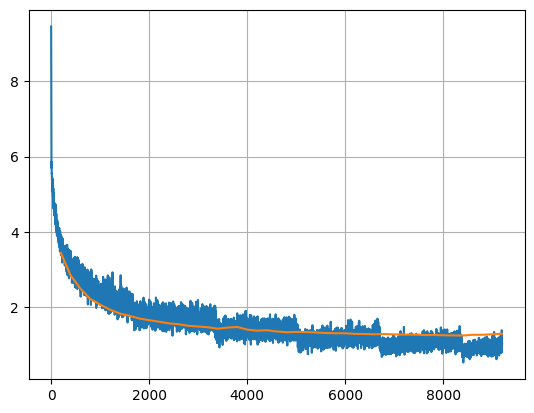

In [35]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.show()

## 推理

- 翻译项目的评估指标一般是BLEU4，感兴趣的同学自行了解并实现
- 接下来进行翻译推理，并作出注意力的热度图

In [36]:
# 加载已保存的模型检查点，模型进行上线
model = Sequence2Sequence(len(src_word2idx), len(trg_word2idx))
# 载入训练时保存的模型参数，参数存储在指定路径
model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_location="cpu",weights_only=True))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        """初始化Translator类
        
        Args:
            - model: 训练好的模型，用于推理和生成翻译
            - src_tokenizer: 源语言的tokenizer，用于编码输入句子
            - trg_tokenizer: 目标语言的tokenizer，用于解码输出句子
        """
        self.model = model
        self.model.eval()  # 将模型设置为评估模式，禁用dropout等训练时特有的机制
        self.src_tokenizer = src_tokenizer  # 源语言tokenizer
        self.trg_tokenizer = trg_tokenizer  # 目标语言tokenizer

    def draw_attention_map(self, scores, src_words_list, trg_words_list):
        """绘制注意力热力图

        该函数用于展示注意力分数的矩阵，可以可视化源语言和目标语言之间的注意力关系。

        Args:
            - scores (numpy.ndarray): 形状为 [source sequence length, target sequence length] 的矩阵
            - src_words_list (list): 源语言句子的单词列表
            - trg_words_list (list): 目标语言句子的单词列表
        """
        plt.matshow(scores.T, cmap='viridis')  # 使用viridis色图显示注意力矩阵
        ax = plt.gca()  # 获取当前的轴

        # 为热图中的每个单元格添加分数值的文本
        for i in range(scores.shape[0]):  # 遍历源语言句子的长度
            for j in range(scores.shape[1]):  # 遍历目标语言句子的长度
                ax.text(j, i, f'{scores[i, j]:.2f}',  # 格式化为两位小数显示
                        ha='center', va='center', color='k')  # 设置文本的对齐方式和颜色

        # 设置x轴和y轴的标签为源语言和目标语言的单词
        plt.xticks(range(scores.shape[0]), src_words_list)
        plt.yticks(range(scores.shape[1]), trg_words_list)
        plt.show()  # 显示绘制的热力图

    def __call__(self, sentence):
        """对输入句子进行翻译，并绘制注意力热力图

        该方法接收一个源语言句子，进行预处理、编码、模型推理和解码，并返回翻译结果。

        Args:
            - sentence (str): 输入的源语言句子
        
        Returns:
            - str: 翻译后的目标语言句子
        """
        sentence = preprocess_sentence(sentence)  # 预处理输入的句子（例如去除标点符号等）
        
        # 使用源语言的tokenizer对句子进行编码，返回编码后的输入和attention mask
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,  # 在输入句子前面补齐
            add_bos=True,  # 添加BOS (开始符)
            add_eos=True,  # 添加EOS (结束符)
            return_mask=True,  # 返回attention mask
        )
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64)  # 转换为Tensor并指定数据类型为int64

        # 使用模型进行推理，获取预测结果和注意力分数
        preds, scores = model.infer(encoder_input=encoder_input, attn_mask=attn_mask)

        # 使用目标语言tokenizer解码预测结果，去除EOS符号
        trg_sentence = self.trg_tokenizer.decode([preds], split=True, remove_eos=False)[0]

        # 对源语言的编码id进行解码，转换为对应的文字（用于绘制注意力图）
        src_decoded = self.src_tokenizer.decode(
            encoder_input.tolist(),
            split=True,
            remove_bos=False,
            remove_eos=False
        )[0]

        # 绘制注意力热力图
        self.draw_attention_map(
            scores.squeeze(0).numpy(),  # 将注意力分数转为numpy数组并去掉多余的维度
            src_decoded,  # 源语言句子（用于绘图）
            trg_sentence  # 目标语言句子（用于绘图）
        )

        # 返回翻译结果（去除最后的EOS符号）
        return " ".join(trg_sentence[:-1])  # 去掉目标语言句子中的EOS符号并返回

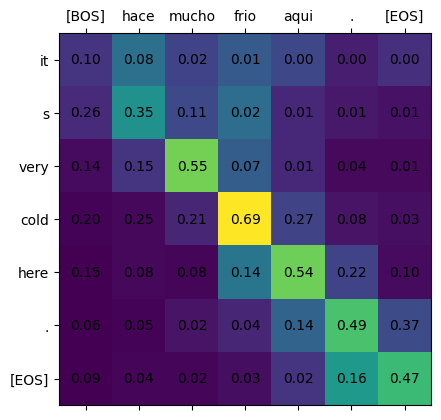

'it s very cold here .'

In [37]:
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
translator(u'hace mucho frio aqui .')

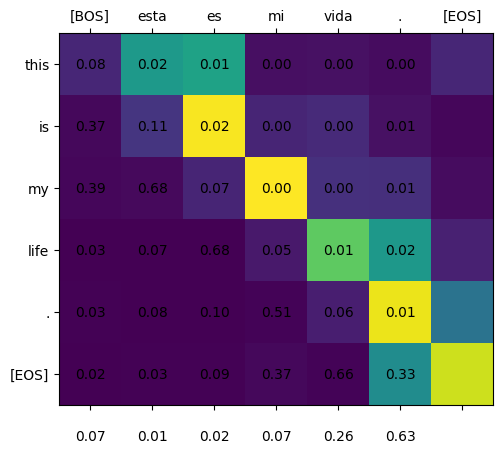

'this is my life .'

In [38]:
translator(u'esta es mi vida.')

In [39]:
from tqdm import tqdm  # 导入 tqdm 库
from nltk.translate.bleu_score import sentence_bleu
import torch

# 加载训练好的模型并进行上线
model = Sequence2Sequence(len(src_word2idx), len(trg_word2idx))
# 载入保存的模型参数，模型存储路径为"./checkpoints/translate-seq2seq/best.ckpt"，并指定设备为cpu
model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_location="cpu",weights_only=True))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        """
        初始化翻译器类，用于对输入句子进行翻译并返回翻译结果。

        Args:
            - model: 训练好的Sequence2Sequence模型
            - src_tokenizer: 用于源语言的tokenizer
            - trg_tokenizer: 用于目标语言的tokenizer
        """
        self.model = model  # 保存模型
        self.model.eval()  # 设置模型为评估模式，禁用dropout等训练时特有的机制
        self.src_tokenizer = src_tokenizer  # 保存源语言tokenizer
        self.trg_tokenizer = trg_tokenizer  # 保存目标语言tokenizer

    def __call__(self, sentence):
        """
        对输入的句子进行翻译，生成目标语言句子。

        Args:
            - sentence: 输入的源语言句子

        Returns:
            - str: 生成的目标语言翻译句子
        """
        sentence = preprocess_sentence(sentence)  # 预处理输入的句子，处理标点符号等

        # 使用源语言tokenizer对输入句子进行编码，返回编码后的输入序列和attention mask
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,  # 在句子前添加padding
            add_bos=True,  # 在句子前添加BOS（开始符号）
            add_eos=True,  # 在句子后添加EOS（结束符号）
            return_mask=True,  # 返回attention mask
        )
        
        # 将编码后的输入序列转换为Tensor，并指定数据类型为int64
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64)

        # 使用模型进行推理，得到预测的目标语言句子及其对应的注意力分数
        preds, scores = model.infer(encoder_input=encoder_input, attn_mask=attn_mask)

        # 使用目标语言的tokenizer将预测的token序列解码为目标语言句子
        trg_sentence = self.trg_tokenizer.decode([preds], split=True, remove_eos=False)[0]

        # 返回生成的目标语言句子，并去除EOS符号
        return " ".join(trg_sentence[:-1])

def evaluate_bleu_on_test_set(test_data, translator):
    """
    在测试集上计算并返回模型的平均BLEU分数。
    
    Args:
        - test_data: 测试数据，格式为[(src_sentence, [ref_translation1, ref_translation2, ...]), ...]
        - translator: 已训练好的翻译器对象（Translator类的实例）

    Returns:
        - float: 平均BLEU分数
    """
    total_bleu = 0.0  # 用于累加BLEU分数
    num_samples = len(test_data)  # 测试集样本数

    # 使用 tqdm 包装循环，显示进度条
    for src_sentence, ref_translations in tqdm(test_data, desc="Evaluating BLEU", total=num_samples):
        # 使用翻译器生成候选翻译结果
        candidate_translation = translator(src_sentence)

        # 使用nltk的sentence_bleu函数计算BLEU分数
        bleu_score = sentence_bleu([ref_translations.split()], candidate_translation.split(), weights=(1, 0, 0, 0))

        # 将当前句子的BLEU分数累加到总分中
        total_bleu += bleu_score

    # 计算并返回平均BLEU分数
    avg_bleu = total_bleu / num_samples
    return avg_bleu

# 创建翻译器实例
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)

# 在测试集上计算BLEU分数并显示进度条
avg_bleu = evaluate_bleu_on_test_set(test_ds, translator)
print(f"Average BLEU score: {avg_bleu:.4f}")

Evaluating BLEU:   0%|          | 0/11705 [00:00<?, ?it/s]C:\Program Files\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Program Files\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Program Files\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consi

Average BLEU score: 0.7069
